<a href="https://colab.research.google.com/github/trihanda/Data-Crime-Rate-Prediction-in-Chicago/blob/main/Chicago_Crime_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bussiness Understanding**

Dataset Chicago_Crime ini memberi informasi tentang kejahatan yang tercatat di Chicago dan terupdate setiap hari.

Menurut data Sensus Amerika Serikat pada tahun 2020, sekitar 82,3% penduduk Amerika Serikat tinggal di daerah perkotaan. Dengan tingginya tingkat populasi perkotaan, penting untuk mengawasi tingkat kriminal. Dengan demikian, pemerintah dapat menegakkan sistem kepolisian cerdas yang akan membantu mereka dalam mengendalikan tingkat kriminal.

Dengan menggunakan data yang tersedia secara terbuka di bigquery-public-data ini, saya akan mencoba menemukan pola dalam aktivitas kriminal ini (pola seperti, apakah satu jenis kejahatan lebih sering daripada yang lain, apakah satu wilayah Chicago lebih tidak aman daripada yang lain, dll.) dan dengan model yang akan membantu kita dalam memprediksi kejahatan.

Goal : Prediksi Jumlah Kejahatan Selama 2 tahun ke depan

**Prediksi Angka Kejahatan di Chicago**

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

In [ ]:
from google.colab import auth
from google.cloud import bigquery

# Autentikasi akun Google
auth.authenticate_user()

# Membuat klien BigQuery
project_id = "dazzling-alpha-381312"
client = bigquery.Client(project=project_id)

In [ ]:
# Menjalankan query
query = """
SELECT *
FROM `bigquery-public-data.chicago_crime.crime`
"""

# Menyimpan hasil query sebagai tabel baru di proyek
destination_table = f"{project_id}.chicago_crime.crime"
job_config = bigquery.QueryJobConfig(destination=destination_table)
query_job = client.query(query, job_config=job_config)
query_job.result()  # Menunggu hingga query selesai dan hasilnya disimpan sebagai tabel baru

In [ ]:
# Menjalankan query untuk mengambil data dari tabel "crime" di dataset "chicago_crime"
query = """
SELECT *
FROM `dazzling-alpha-381312.chicago_crime.crime`
"""

# Menjalankan query dan menyimpan hasilnya dalam DataFrame
df = client.query(query).to_dataframe()

In [ ]:
df.head()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,8282125,HT516658,2011-09-26 04:30:00+00:00,003XX W 101ST PL,1305,CRIMINAL DAMAGE,CRIMINAL DEFACEMENT,RESIDENCE-GARAGE,False,False,...,9,49,14,1175814.0,1837624.0,2011,2016-02-04 06:33:39+00:00,41.709803,-87.631749,"(41.709802599, -87.631749408)"
1,9703147,HX353696,2014-07-19 12:03:00+00:00,025XX W CERMAK RD,1140,DECEPTIVE PRACTICE,EMBEZZLEMENT,BANK,False,False,...,25,31,12,1159905.0,1889319.0,2014,2018-02-10 03:50:01+00:00,41.852002,-87.688591,"(41.852001828, -87.688591335)"
2,12589702,JF108848,2015-10-25 12:01:00+00:00,045XX S HERMITAGE AVE,1752,OFFENSE INVOLVING CHILDREN,AGGRAVATED CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,...,15,61,17,NaN,NaN,2015,2022-09-20 04:53:29+00:00,NaN,NaN,None
3,4930176,HM543071,2006-08-16 04:31:39+00:00,092XX S STONY ISLAND AVE,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,HOTEL/MOTEL,False,False,...,8,48,17,1188516.0,1844213.0,2006,2018-02-28 03:56:25+00:00,41.727590,-87.585024,"(41.727590123, -87.585023579)"
4,9720485,HX370289,2014-08-01 11:55:00+00:00,040XX S HALSTED ST,3710,INTERFERENCE WITH PUBLIC OFFICER,RESIST/OBSTRUCT/DISARM OFFICER,VEHICLE NON-COMMERCIAL,True,False,...,11,61,24,1171636.0,1878186.0,2014,2018-02-10 03:50:01+00:00,41.821202,-87.645863,"(41.821202117, -87.645862609)"


    unique_key: Unique identifier for the crime incident.
    case_number: Records Division Number assigned to the incident.
    date: Date when the incident occurred.
    block: Block address of the incident.
    iucr: The Illinois Uniform Crime Reporting code.
    primary_type: The primary description of the crime according to the IUCR code.
    description: Secondary description of the incident.
    location_description: Description of the location where the incident occurred.
    arrest: True or False if the convict was arrested.
    domestic: True or False if the incident was domestic-related.
    beat: A beat is the smallest police geographic area — each beat has a dedicated police beat car.
    district: District where the incident occurred.
    ward: The City Council district where the incident occurred.
    community_area: Chicago has 77 community areas.
    fbi_code: Crime classification according to FBI’s National Incident-Based Reporting System (NIBRS).
    x_coordinate: The x coordinate of the incident.
    y_coordinate: The y coordinate of the incident.
    year: Year the incident occurred.
    updated_on: Date and time the record was last updated.
    latitude: The latitude of the incident.
    longitude: The longitude of the incident.
    location: The location of the incident

In [ ]:
# Mengurutkan DataFrame berdasarkan kolom date
df_sorted = df.sort_values(by='date')

**1. Display Top 5 Rows of The DataFrame**

In [ ]:
# Menampilkan 5 baris pertama (head) dari DataFrame yang sudah diurutkan
df_sorted.head()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
624841,3769790,HL141452,2001-01-01 01:00:00+00:00,121XX S LOWE AVE,0842,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,False,...,34,53,06,1174215.0,1824262.0,2001,2006-03-31 10:03:38+00:00,41.673171,-87.638000,"(41.673170821, -87.638000169)"
6704694,1311144,G001320,2001-01-01 01:00:00+00:00,063XX N LEAVITT ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,<NA>,<NA>,14,1160455.0,1942042.0,2001,2015-08-17 03:03:40+00:00,41.996666,-87.685110,"(41.99666603, -87.685109858)"
999122,5462733,HN290220,2001-01-01 01:00:00+00:00,058XX S INDIANA AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,...,20,40,20,1178551.0,1866538.0,2001,2007-04-25 05:57:12+00:00,41.789084,-87.620849,"(41.789084341, -87.620849345)"
1933360,1315701,G003835,2001-01-01 01:00:00+00:00,011XX S PULASKI RD,041A,BATTERY,AGGRAVATED: HANDGUN,RESIDENCE,False,False,...,<NA>,<NA>,04B,1149936.0,1894501.0,2001,2015-08-17 03:03:40+00:00,41.866421,-87.725046,"(41.866421432, -87.72504577)"
1320792,1311503,G001102,2001-01-01 01:00:00+00:00,026XX N HALSTED ST,0264,CRIM SEXUAL ASSAULT,AGGRAVATED: OTHER DANG WEAPON,BAR OR TAVERN,False,False,...,<NA>,<NA>,02,1170510.0,1918326.0,2001,2015-08-17 03:03:40+00:00,41.931374,-87.648819,"(41.931373805, -87.648818936)"


**2. Display Last 5 Rows of The DataFrame**

In [ ]:
# Menampilkan 5 baris terakhir (tail) dari DataFrame yang sudah diurutkan
df_sorted.tail()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
2382954,13148819,JG351040,2023-07-22 12:53:00+00:00,004XX E OHIO ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,2,8,08B,1179307.0,1904288.0,2023,2023-07-29 04:53:57+00:00,41.892656,-87.616923,"(41.892655759, -87.616922817)"
2803166,13148836,JG351022,2023-07-22 12:54:00+00:00,026XX E 83RD ST,051A,ASSAULT,AGGRAVATED - HANDGUN,STREET,False,False,...,7,46,04A,1195030.0,1850444.0,2023,2023-07-29 04:53:57+00:00,41.744531,-87.560957,"(41.744530644, -87.560957353)"
4764166,13148849,JG351045,2023-07-22 12:58:00+00:00,014XX W MONTROSE AVE,0860,THEFT,RETAIL THEFT,SMALL RETAIL STORE,False,False,...,47,6,06,1165635.0,1929313.0,2023,2023-07-29 04:53:57+00:00,41.961628,-87.666419,"(41.961628063, -87.666419454)"
751140,13149327,JG351552,2023-07-22 12:59:00+00:00,032XX W MAYPOLE AVE,0650,BURGLARY,HOME INVASION,APARTMENT,False,True,...,28,27,05,1154662.0,1900797.0,2023,2023-07-29 04:53:57+00:00,41.883605,-87.707528,"(41.88360511, -87.70752754)"
5301579,13149356,JG351563,2023-07-22 12:59:00+00:00,0000X N STATE ST,0860,THEFT,RETAIL THEFT,DEPARTMENT STORE,True,False,...,34,32,06,1176363.0,1900552.0,2023,2023-07-29 04:53:57+00:00,41.882471,-87.627848,"(41.882470918, -87.627847625)"


In [ ]:
# Filter data dari tanggal 01 Januari 2001 hingga 31 Desember 2022
df_filtered = df[(df['date'] >= '2001-01-01') & (df['date'] <= '2022-12-31')]

In [ ]:
df_filtered_sorted = df_filtered.sort_values(by='date')

In [ ]:
df_filtered_sorted.head()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
3932719,1313086,G004657,2001-01-01 01:00:00+00:00,039XX N DRAKE AV,0810,THEFT,OVER $500,OTHER,False,False,...,<NA>,<NA>,06,1151978.0,1926092.0,2001,2015-08-17 03:03:40+00:00,41.953070,-87.716716,"(41.953070112, -87.716715611)"
3696032,1316324,G002222,2001-01-01 01:00:00+00:00,059XX W ARTHINGTON ST,0810,THEFT,OVER $500,STREET,False,False,...,<NA>,<NA>,06,1136610.0,1895353.0,2001,2015-08-17 03:03:40+00:00,41.869008,-87.773947,"(41.869008134, -87.77394715)"
4870595,6154338,HP242745,2001-01-01 01:00:00+00:00,065XX S KEDZIE AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,...,15,66,06,1156214.0,1861165.0,2001,2008-04-02 01:05:33+00:00,41.774819,-87.702896,"(41.774818809, -87.702896431)"
6441415,1311626,G001009,2001-01-01 01:00:00+00:00,023XX S TROY ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,<NA>,<NA>,14,1155692.0,1888116.0,2001,2015-08-17 03:03:40+00:00,41.848786,-87.704087,"(41.848786421, -87.704086603)"
4825363,1309918,G000412,2001-01-01 01:00:00+00:00,032XX N SHEFFIELD AV,0820,THEFT,$500 AND UNDER,TAVERN/LIQUOR STORE,False,False,...,<NA>,<NA>,06,1169005.0,1921458.0,2001,2015-08-17 03:03:40+00:00,41.940001,-87.654258,"(41.940000996, -87.654258339)"


In [ ]:
df_filtered_sorted.tail()

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
3161309,12936580,JF527061,2022-12-30 12:48:00+00:00,105XX S WENTWORTH AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,...,34,49,08B,1176814.0,1835095.0,2022,2023-01-06 03:49:11+00:00,41.702840,-87.628163,"(41.702840251, -87.628163116)"
7715837,12941473,JG102193,2022-12-30 12:50:00+00:00,110XX S AVENUE O,4387,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,RESIDENCE,False,True,...,10,52,26,NaN,NaN,2022,2023-01-06 03:49:11+00:00,NaN,NaN,None
6443387,12936667,JF527060,2022-12-30 12:53:00+00:00,051XX S WABASH AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,3,40,14,1177588.0,1870887.0,2022,2023-01-06 03:49:11+00:00,41.801040,-87.624249,"(41.80104026, -87.624248783)"
1845006,12936568,JF527052,2022-12-30 12:57:00+00:00,091XX S ASHLAND AVE,041A,BATTERY,AGGRAVATED - HANDGUN,STREET,False,False,...,21,73,04B,1167278.0,1844042.0,2022,2023-01-06 03:49:11+00:00,41.727601,-87.662826,"(41.727601186, -87.662826492)"
6375181,12937578,JF527554,2022-12-30 12:58:00+00:00,080XX S CHAMPLAIN AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,6,44,14,1181963.0,1851773.0,2022,2023-01-06 03:49:11+00:00,41.748489,-87.608795,"(41.748489444, -87.608794866)"


In [ ]:
# Filter data untuk tanggal 31 Desember 2022
date_to_view = '2022-12-31'
df_specific_date = df[df['date'] == date_to_view]

# Cetak DataFrame dengan data pada tanggal tertentu
print(df_specific_date)

Empty DataFrame
Columns: [unique_key, case_number, date, block, iucr, primary_type, description, location_description, arrest, domestic, beat, district, ward, community_area, fbi_code, x_coordinate, y_coordinate, year, updated_on, latitude, longitude, location]
Index: []

[0 rows x 22 columns]


**3. Find Shape of Our DataFrame (Number of Rows And Number of Columns)**

In [ ]:
shape = df_filtered_sorted.shape
num_rows = shape[0]
num_columns = shape[1]

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 7711850
Number of columns: 22


**4. Get Information About Our DataFrame Like Total Number Rows, Total Number of Columns, Datatypes of Each Column And Memory Requirement**

In [ ]:
df_filtered_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7711850 entries, 3932719 to 6375181
Data columns (total 22 columns):
 #   Column                Dtype              
---  ------                -----              
 0   unique_key            Int64              
 1   case_number           object             
 2   date                  datetime64[ns, UTC]
 3   block                 object             
 4   iucr                  object             
 5   primary_type          object             
 6   description           object             
 7   location_description  object             
 8   arrest                boolean            
 9   domestic              boolean            
 10  beat                  Int64              
 11  district              Int64              
 12  ward                  Int64              
 13  community_area        Int64              
 14  fbi_code              object             
 15  x_coordinate          float64            
 16  y_coordinate          float64 

**5. Check Null Values In The DataFrame**

In [ ]:
df_filtered.isnull().sum()

unique_key                   0
case_number                  4
date                         0
block                        0
iucr                         0
primary_type                 0
description                  0
location_description     10209
arrest                       0
domestic                     0
beat                         0
district                    47
ward                    614846
community_area          613551
fbi_code                     0
x_coordinate             87450
y_coordinate             87450
year                         0
updated_on                   0
latitude                 87332
longitude                87332
location                 87332
dtype: int64

**6. Select Only The Necessary Columns**

In [ ]:
df_filtered.columns

Index(['unique_key', 'case_number', 'date', 'block', 'iucr', 'primary_type',
       'description', 'location_description', 'arrest', 'domestic', 'beat',
       'district', 'ward', 'community_area', 'fbi_code', 'x_coordinate',
       'y_coordinate', 'year', 'updated_on', 'latitude', 'longitude',
       'location'],
      dtype='object')

In [ ]:
selected_columns = ['unique_key','date','primary_type','location_description','arrest','domestic']

In [ ]:
df_selected = df_filtered[selected_columns]

In [ ]:
df_selected.head()

,unique_key,date,primary_type,location_description,arrest,domestic
0,8282125,2011-09-26 04:30:00+00:00,CRIMINAL DAMAGE,RESIDENCE-GARAGE,False,False
1,9703147,2014-07-19 12:03:00+00:00,DECEPTIVE PRACTICE,BANK,False,False
2,12589702,2015-10-25 12:01:00+00:00,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,True
3,4930176,2006-08-16 04:31:39+00:00,SEX OFFENSE,HOTEL/MOTEL,False,False
4,9720485,2014-08-01 11:55:00+00:00,INTERFERENCE WITH PUBLIC OFFICER,VEHICLE NON-COMMERCIAL,True,False


**7.Check Null Values In The DataFrame Selected**

In [ ]:
df_selected.isnull().sum()

unique_key                  0
date                        0
primary_type                0
location_description    10209
arrest                      0
domestic                    0
dtype: int64

In [ ]:
df_selected = df_selected.dropna()

In [ ]:
df_selected.isnull().sum()

unique_key              0
date                    0
primary_type            0
location_description    0
arrest                  0
domestic                0
dtype: int64

In [ ]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7701641 entries, 0 to 7853098
Data columns (total 6 columns):
 #   Column                Dtype              
---  ------                -----              
 0   unique_key            Int64              
 1   date                  datetime64[ns, UTC]
 2   primary_type          object             
 3   location_description  object             
 4   arrest                boolean            
 5   domestic              boolean            
dtypes: Int64(1), boolean(2), datetime64[ns, UTC](1), object(2)
memory usage: 330.5+ MB


**8. Find The Top 10 Primary Crime Types**

In [ ]:
df_selected['primary_type'].value_counts().head(10)

THEFT                  1626153
BATTERY                1410740
CRIMINAL DAMAGE         878778
NARCOTICS               746142
ASSAULT                 501035
OTHER OFFENSE           478985
BURGLARY                422217
MOTOR VEHICLE THEFT     366493
DECEPTIVE PRACTICE      331270
ROBBERY                 289644
Name: primary_type, dtype: int64

**9. How Many Criminals Are Arrested Having Primary Crime type is Theft?**

In [ ]:
df_selected[df_selected['primary_type']=="THEFT"]['arrest'].value_counts()

False    1443244
True      182909
Name: arrest, dtype: Int64

**10. Find The Top 10 Crime Location Descriptions**

In [ ]:
df_selected['location_description'].value_counts().head(10)

STREET                            2004934
RESIDENCE                         1296953
APARTMENT                          865419
SIDEWALK                           725847
OTHER                              270017
PARKING LOT/GARAGE(NON.RESID.)     202985
ALLEY                              171215
SCHOOL, PUBLIC, BUILDING           146387
SMALL RETAIL STORE                 145188
RESIDENCE-GARAGE                   135543
Name: location_description, dtype: int64

**11. How Many of Are Arrested Having Location Type is STREET**

In [ ]:
df_selected[df_selected['location_description']=="STREET"]['arrest'].value_counts()

False    1453104
True      551830
Name: arrest, dtype: Int64

In [ ]:
df_selected.index = pd.DatetimeIndex(df_selected.date)

In [ ]:
df_selected

,unique_key,date,primary_type,location_description,arrest,domestic
date,,,,,,
2011-09-26 04:30:00+00:00,8282125,2011-09-26 04:30:00+00:00,CRIMINAL DAMAGE,RESIDENCE-GARAGE,False,False
2014-07-19 12:03:00+00:00,9703147,2014-07-19 12:03:00+00:00,DECEPTIVE PRACTICE,BANK,False,False
2015-10-25 12:01:00+00:00,12589702,2015-10-25 12:01:00+00:00,OFFENSE INVOLVING CHILDREN,RESIDENCE,False,True
2006-08-16 04:31:39+00:00,4930176,2006-08-16 04:31:39+00:00,SEX OFFENSE,HOTEL/MOTEL,False,False
2014-08-01 11:55:00+00:00,9720485,2014-08-01 11:55:00+00:00,INTERFERENCE WITH PUBLIC OFFICER,VEHICLE NON-COMMERCIAL,True,False
...,...,...,...,...,...,...
2004-10-22 02:55:00+00:00,3610919,2004-10-22 02:55:00+00:00,OTHER OFFENSE,APARTMENT,True,True
2007-03-14 11:25:00+00:00,5377853,2007-03-14 11:25:00+00:00,OTHER OFFENSE,APARTMENT,True,True
2003-12-03 08:39:00+00:00,3077991,2003-12-03 08:39:00+00:00,OTHER OFFENSE,APARTMENT,True,False


Text(0, 0.5, 'Number of Crimes')

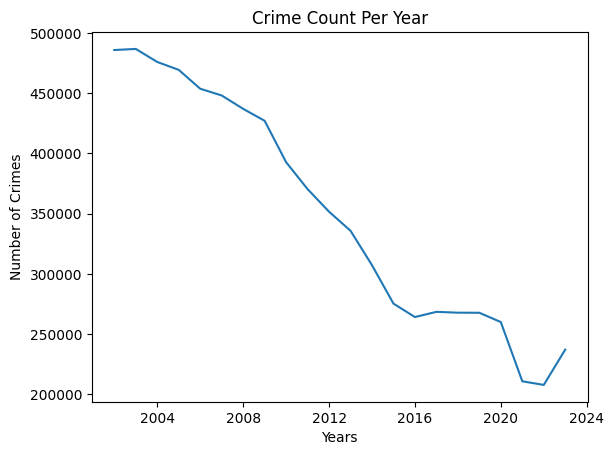

In [ ]:
plt.plot(df_selected.resample('Y').size())
plt.title("Crime Count Per Year")
plt.xlabel("Years")
plt.ylabel("Number of Crimes")

Text(0, 0.5, 'Number of Crimes')

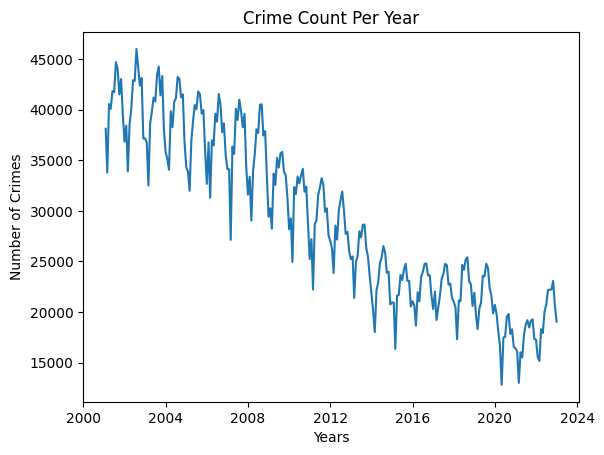

In [ ]:
plt.plot(df_selected.resample('M').size())
plt.title("Crime Count Per Year")
plt.xlabel("Years")
plt.ylabel("Number of Crimes")

**Preparing The Data**

In [ ]:
df_prophet = pd.DataFrame(df_selected.resample('M').size().reset_index())

In [ ]:
df_prophet.columns =['Date','Crime Count']

In [ ]:
df_prophet

,Date,Crime Count
0,2001-01-31 00:00:00+00:00,38119
1,2001-02-28 00:00:00+00:00,33787
2,2001-03-31 00:00:00+00:00,40564
3,2001-04-30 00:00:00+00:00,40091
4,2001-05-31 00:00:00+00:00,41839
...,...,...
259,2022-08-31 00:00:00+00:00,22220
260,2022-09-30 00:00:00+00:00,22224
261,2022-10-31 00:00:00+00:00,23089
262,2022-11-30 00:00:00+00:00,20692


**Rename The Columns**

In [ ]:
# ds and y

In [ ]:
df_prophet=df_prophet.rename(columns={'Date':'ds','Crime Count':'y'})

In [ ]:
df_prophet

,ds,y
0,2001-01-31 00:00:00+00:00,38119
1,2001-02-28 00:00:00+00:00,33787
2,2001-03-31 00:00:00+00:00,40564
3,2001-04-30 00:00:00+00:00,40091
4,2001-05-31 00:00:00+00:00,41839
...,...,...
259,2022-08-31 00:00:00+00:00,22220
260,2022-09-30 00:00:00+00:00,22224
261,2022-10-31 00:00:00+00:00,23089
262,2022-11-30 00:00:00+00:00,20692


In [ ]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

In [ ]:
df_prophet

,ds,y
0,2001-01-31,38119
1,2001-02-28,33787
2,2001-03-31,40564
3,2001-04-30,40091
4,2001-05-31,41839
...,...,...
259,2022-08-31,22220
260,2022-09-30,22224
261,2022-10-31,23089
262,2022-11-30,20692


**Train The Model**

In [ ]:
m = Prophet()
m.fit(df_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy0asyen8/pfisdli4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy0asyen8/77pd850e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23703', 'data', 'file=/tmp/tmpy0asyen8/pfisdli4.json', 'init=/tmp/tmpy0asyen8/77pd850e.json', 'output', 'file=/tmp/tmpy0asyen8/prophet_modelfd2kojem/prophet_model-20230731080251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:02:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Make The Predictions**

In [ ]:
pred=m.make_future_dataframe(periods=24,freq='M')
forcast = m.predict(pred)

In [ ]:
forcast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-31,41712.592708,36973.313120,40612.643080,41712.592708,41712.592708,-2970.682522,-2970.682522,-2970.682522,-2970.682522,-2970.682522,-2970.682522,0.0,0.0,0.0,38741.910186
1,2001-02-28,41655.156326,34316.557758,37971.992953,41655.156326,41655.156326,-5501.960649,-5501.960649,-5501.960649,-5501.960649,-5501.960649,-5501.960649,0.0,0.0,0.0,36153.195678
2,2001-03-31,41591.566046,38515.115223,42110.790341,41591.566046,41591.566046,-1215.917382,-1215.917382,-1215.917382,-1215.917382,-1215.917382,-1215.917382,0.0,0.0,0.0,40375.648664
3,2001-04-30,41530.027066,38502.537196,41924.620023,41530.027066,41530.027066,-1402.080823,-1402.080823,-1402.080823,-1402.080823,-1402.080823,-1402.080823,0.0,0.0,0.0,40127.946243
4,2001-05-31,41466.436786,40886.052501,44713.585368,41466.436786,41466.436786,1307.866023,1307.866023,1307.866023,1307.866023,1307.866023,1307.866023,0.0,0.0,0.0,42774.302809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2024-08-31,17174.699349,18341.655183,22066.479964,16992.634256,17358.152840,3043.721687,3043.721687,3043.721687,3043.721687,3043.721687,3043.721687,0.0,0.0,0.0,20218.421036
284,2024-09-30,17120.133835,16543.941114,20124.451337,16925.822221,17324.829347,1216.869985,1216.869985,1216.869985,1216.869985,1216.869985,1216.869985,0.0,0.0,0.0,18337.003820
285,2024-10-31,17063.749470,16655.840680,20310.411590,16854.253512,17282.340963,1370.012067,1370.012067,1370.012067,1370.012067,1370.012067,1370.012067,0.0,0.0,0.0,18433.761537
286,2024-11-30,17009.183956,13883.572615,17474.449629,16781.605199,17244.682667,-1335.284776,-1335.284776,-1335.284776,-1335.284776,-1335.284776,-1335.284776,0.0,0.0,0.0,15673.899180


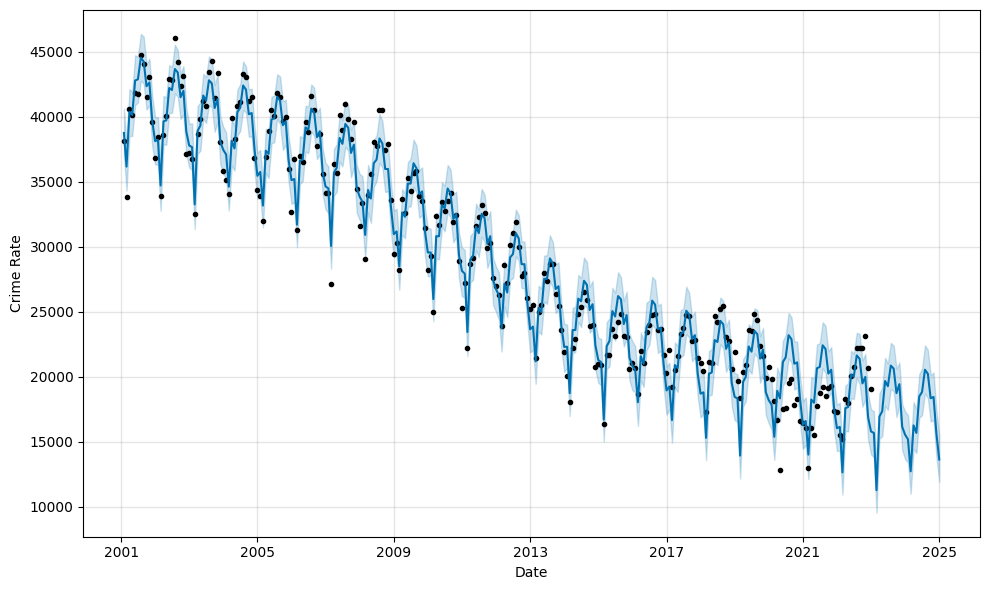

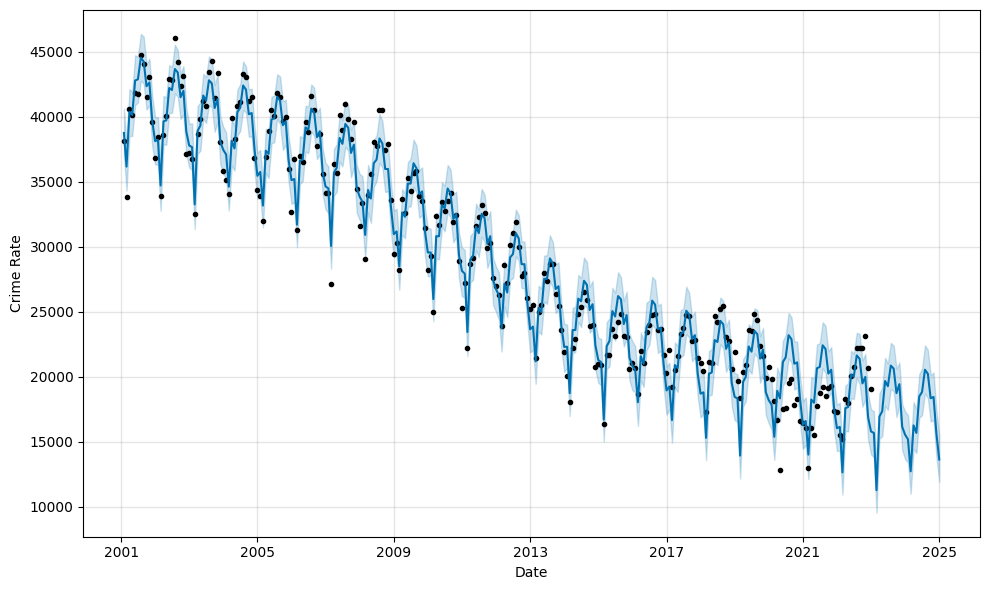

In [ ]:
m.plot(forcast,xlabel="Date",ylabel="Crime Rate")

**Save The Model**

In [ ]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('prophet_model.json', 'w') as fout:
    json.dump(model_to_json(m), fout)  # Save model

In [ ]:
with open('prophet_model.json', 'r') as fin:
    m1 = model_from_json(json.load(fin))  # Load model

/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:160: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))


In [ ]:
x = int(input("Enter Numbers Months to forecast"))

Enter Numbers Months to forecast24


In [ ]:
pred = m1.make_future_dataframe(periods=x ,freq = "M")
forcast = m1.predict(pred)

In [ ]:
forcast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2001-01-31,41712.592708,36942.550658,40502.661606,41712.592708,41712.592708,-2970.682522,-2970.682522,-2970.682522,-2970.682522,-2970.682522,-2970.682522,0.0,0.0,0.0,38741.910186
1,2001-02-28,41655.156326,34315.311634,37955.386984,41655.156326,41655.156326,-5501.960649,-5501.960649,-5501.960649,-5501.960649,-5501.960649,-5501.960649,0.0,0.0,0.0,36153.195678
2,2001-03-31,41591.566046,38492.217324,42135.725283,41591.566046,41591.566046,-1215.917382,-1215.917382,-1215.917382,-1215.917382,-1215.917382,-1215.917382,0.0,0.0,0.0,40375.648664
3,2001-04-30,41530.027066,38234.373151,42007.432230,41530.027066,41530.027066,-1402.080823,-1402.080823,-1402.080823,-1402.080823,-1402.080823,-1402.080823,0.0,0.0,0.0,40127.946243
4,2001-05-31,41466.436786,41061.269937,44644.425892,41466.436786,41466.436786,1307.866023,1307.866023,1307.866023,1307.866023,1307.866023,1307.866023,0.0,0.0,0.0,42774.302809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,2024-08-31,17174.699349,18472.364026,22003.863942,17006.039565,17339.476944,3043.721687,3043.721687,3043.721687,3043.721687,3043.721687,3043.721687,0.0,0.0,0.0,20218.421036
284,2024-09-30,17120.133835,16506.738899,20085.430003,16934.367185,17297.250437,1216.869985,1216.869985,1216.869985,1216.869985,1216.869985,1216.869985,0.0,0.0,0.0,18337.003820
285,2024-10-31,17063.749470,16741.834920,20282.434810,16858.368635,17253.875303,1370.012067,1370.012067,1370.012067,1370.012067,1370.012067,1370.012067,0.0,0.0,0.0,18433.761537
286,2024-11-30,17009.183956,13928.582437,17524.207204,16790.853769,17216.207114,-1335.284776,-1335.284776,-1335.284776,-1335.284776,-1335.284776,-1335.284776,0.0,0.0,0.0,15673.899180


In [ ]:
#Export as download if in colab
from google.colab import files

#Menyimpan File/Export File to Local computer output Excel file

forcast.to_excel('forecast.xlsx')
files.download('forecast.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

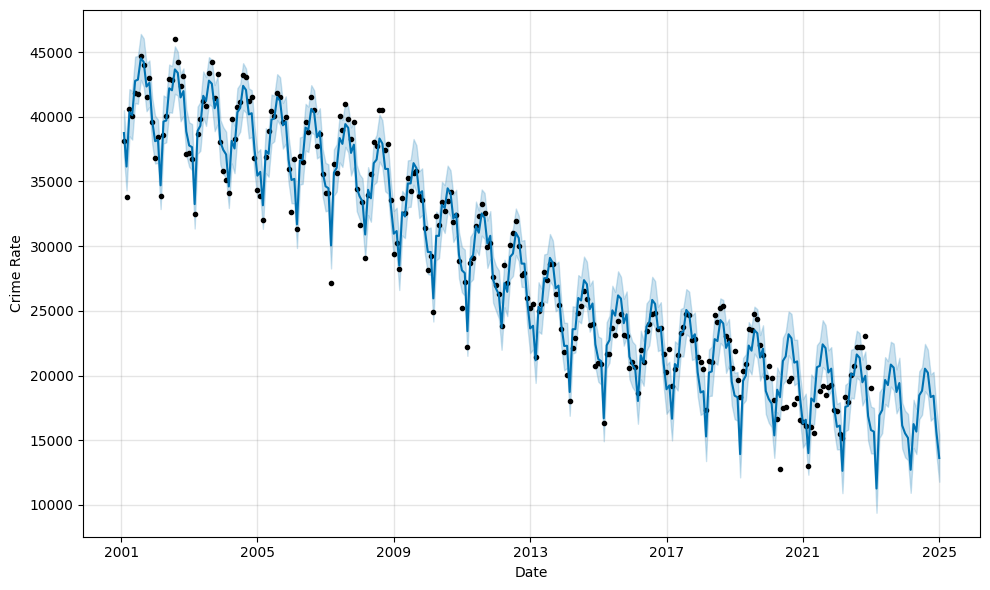

In [ ]:
figure = m1.plot(forcast, xlabel='Date', ylabel='Crime Rate')

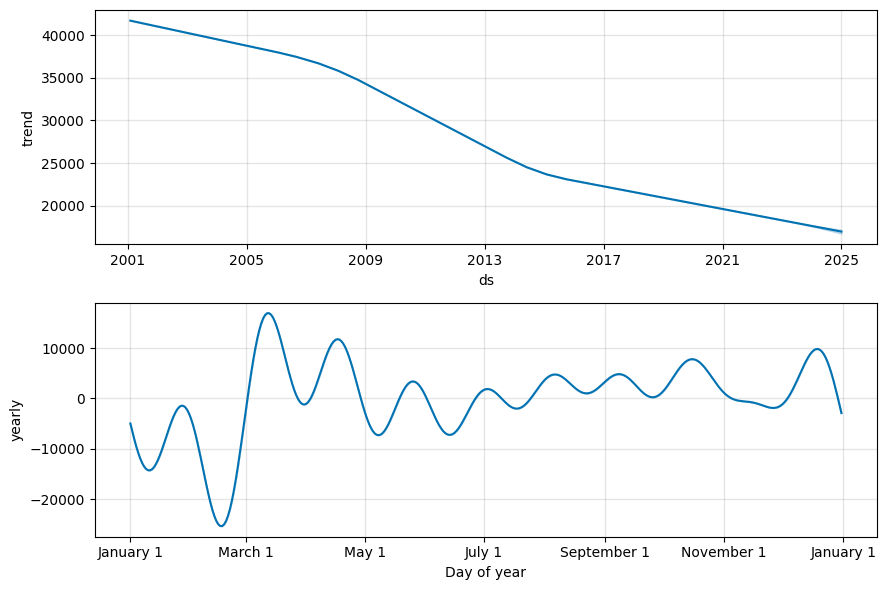

In [ ]:
figure3 = m1.plot_components(forcast)

In [ ]:

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


# Split the data into training and test sets
train_size = int(0.8 * len(df_prophet))
train_df = df_prophet[:train_size]
test_df = df_prophet[train_size:]

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train_df)

# Make predictions on the test set
forecast = model.predict(test_df)

# Extract the predicted values and actual observed values from the forecast DataFrame
y_pred = forecast['yhat'].values
y_true = test_df['y'].values

# Calculate evaluation metrics
mape = mean_absolute_percentage_error(y_true, y_pred)


print("Mean Absolute Percentage Error (MAPE): {:.2f}%".format(mape * 100))

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy0asyen8/zaqemp_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpy0asyen8/04fippm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49171', 'data', 'file=/tmp/tmpy0asyen8/zaqemp_d.json', 'init=/tmp/tmpy0asyen8/04fippm1.json', 'output', 'file=/tmp/tmpy0asyen8/prophet_modelmbtgyvbe/prophet_model-20230731091140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:11:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:11:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Percentage Error (MAPE): 14.04%
